# Assignment 1: $k$-nearest neighbors

In [1]:
%matplotlib widget

In [2]:
import functools as ft
import typing as ty

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as RefKNeighborsClassifier
from tqdm.notebook import tqdm

## 1. Algorithm

```plain-text
function k_nearest_neighbors(x, samples, k, distance)
    dists <- sorted([distance(x, e) for e in samples])
    neighbors <- first k samples with closest distances
    return dominating label within neighbors
endfunction
```

In [3]:
def naive_knn(
    x: np.ndarray,
    samples: np.ndarray,
    labels: np.ndarray,
    n_labels: int,
    k: int,
) -> tuple[int, np.ndarray]:
    dists = np.linalg.norm(samples - x, ord=2, axis=1)
    kni = np.argsort(dists)[:k]
    counts = np.bincount(labels[kni], minlength=n_labels)
    return int(np.argmax(counts)), (counts / k)

## 2. Experiment setup

In [4]:
with np.load("dataset/mnist.npz") as mnist:
    x_train, y_train = mnist['x_train'], mnist['y_train']
    x_test, y_test = mnist['x_test'], mnist['y_test']

x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32) / 255.0
y_train = y_train.astype(np.intp)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32) / 255.0
y_test = y_test.astype(np.intp)

print(f"x_train.shape: {x_train.shape} dtype={x_train.dtype}")
print(f"y_train.shape: {y_train.shape} dtype={y_train.dtype}")
print(f"x_test.shape: {x_test.shape} dtype={x_test.dtype}")
print(f"y_test.shape: {y_test.shape} dtype={y_test.dtype}")

n_labels = max(int(y_train.max()), int(y_test.max())) + 1
print(f"n_labels = {n_labels}")
assert n_labels == 10

x_train.shape: (60000, 784) dtype=float32
y_train.shape: (60000,) dtype=int64
x_test.shape: (10000, 784) dtype=float32
y_test.shape: (10000,) dtype=int64
n_labels = 10


## 3. Verification

We use the `KNeighborsClassifier` provided by scikit-learn as the reference implementation.

In [5]:
N_VERIF = 100

verif_samples = x_test[np.random.choice(x_test.shape[0], size=N_VERIF, replace=False)]
classifier = RefKNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
classifier.fit(x_train, y_train)
for sample in tqdm(verif_samples):
    sample = sample[np.newaxis, :]
    pred_ref = classifier.predict(sample).squeeze(0)
    pred_ref_prob = classifier.predict_proba(sample).squeeze(0)
    pred_uut, pred_uut_prob = naive_knn(sample[0], x_train, y_train, 10, 5)
    assert pred_ref == pred_uut, f"pred_ref={pred_ref}, pred_uut={pred_uut}"
    assert np.allclose(pred_ref_prob, pred_uut_prob), f"pred_ref_prob={pred_ref_prob}, pred_uut_prob={pred_uut_prob}"

  0%|          | 0/100 [00:00<?, ?it/s]

## 4. Evaluation

For prediction performance, we evaluate combinations of:

* Different values for $k$
* With or without feature extraction

For runtime efficiency, we evaluate how dimensionality of the sample vector influence performance.

We use the following metrics for binary prediction evaluation:

* Accuracy $C$, recall rate $R$, precision $P$
* $F_1$ score
* ROC curve and AUC

We then evaluate multi-label prediction by $R$ and $P$.

### 4.1. $k$'s influence on performance

In [6]:
c_against_k: list[tuple[int, float]] = []
for k in tqdm(range(1, 100, 2)):
    classifier = RefKNeighborsClassifier(
        n_neighbors=k, metric="minkowski", p=2
    )
    classifier.fit(x_train, y_train)
    pred = classifier.predict(x_test)
    correct = pred == y_test
    c_against_k.append((k, correct.sum() / x_test.shape[0]))

  0%|          | 0/50 [00:00<?, ?it/s]

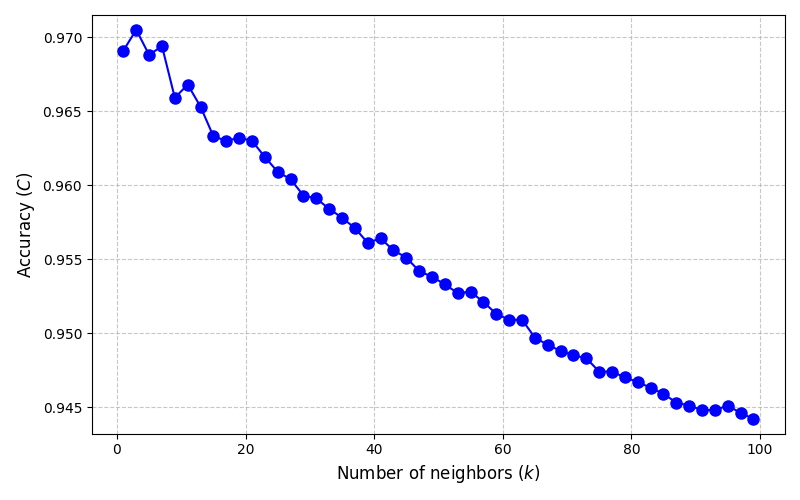

In [7]:
plt.close("all")
fig, ax = plt.subplots(figsize=(8, 5), num="")
fig.canvas.header_visible = False

fac_vec = [k for k, _ in c_against_k]
c_vec = [c for _, c in c_against_k]
c_max, c_min = max(c_vec), min(c_vec)
ax.plot(fac_vec, c_vec, marker="o", linestyle="-", color="blue", markersize=8)
ax.set_ylim(top=min(1.0, c_max + 0.001), bottom=max(0.0, c_min - 0.001))
ax.set_xlabel("Number of neighbors ($k$)", fontsize=12)
ax.set_ylabel("Accuracy ($C$)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 4.2. Feature extraction with PCA

We use Principal Component Analysis tool provided by scikit-learn to reduce the dimensionality of the sample vector.

In [8]:
K = 3

orig_n_dims = x_train.shape[1]
assert x_test.shape[1] == orig_n_dims

fac_acc: list[tuple[int, float]] = []
for fac in tqdm(range(1, 32)):
    n_dims = orig_n_dims // fac
    pca = PCA(n_components=n_dims)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    classifier = RefKNeighborsClassifier(
        n_neighbors=K, metric="minkowski", p=2
    )
    classifier.fit(x_train_pca, y_train)
    pred = classifier.predict(x_test_pca)
    correct = pred == y_test
    accuracy = correct.sum() / x_test.shape[0]
    fac_acc.append((fac, accuracy))

  0%|          | 0/31 [00:00<?, ?it/s]

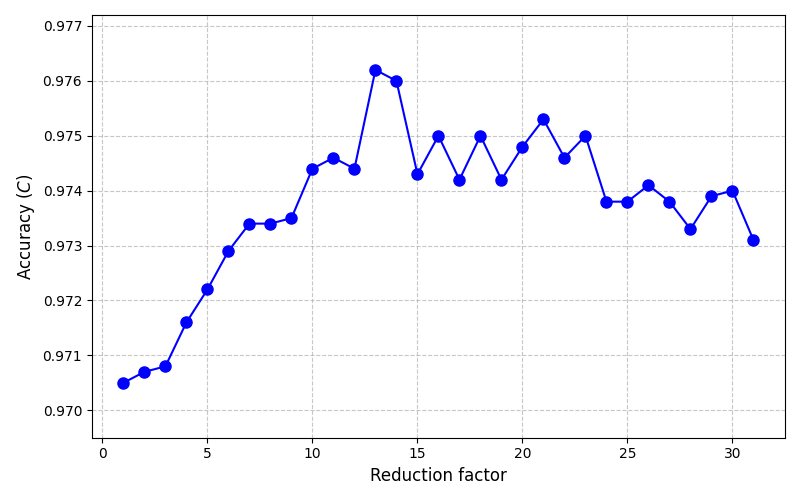

In [9]:
plt.close("all")
fig, ax = plt.subplots(figsize=(8, 5), num="")
fig.canvas.header_visible = False

fac_vec = [fac for fac, _ in fac_acc]
c_vec = [c for _, c in fac_acc]
c_max, c_min = max(c_vec), min(c_vec)
ax.plot(fac_vec, c_vec, marker="o", linestyle="-", color="blue", markersize=8)
ax.set_ylim(top=min(1.0, c_max + 0.001), bottom=max(0.0, c_min - 0.001))
ax.set_xlabel("Reduction factor", fontsize=12)
ax.set_ylabel("Accuracy ($C$)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()